
## Installation
---



In [39]:
from pathlib import Path
import os
from datetime import date
import re
import glob
from tqdm.notebook import tqdm

In [40]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import box
import dask.dataframe as dd
pd.options.mode.chained_assignment = None

In [41]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [42]:
# Paths
p = Path('/Users/alex/Dropbox/Work/GNS/008_FFE/ProbaFFE/FFE')
pathShapefile = p / 'shapefile'
pathParquets = p / 'output'

print(len(os.listdir(pathParquets)))
print(os.listdir(pathShapefile))

2999
['ExcLosses.png', 'CountBurn-2020-08-06.parquet', 'WellWHV_Buildings.dbf', 'BurnscenarioWellington.dbf', 'DistributionLosses.png', '.DS_Store', 'CountBurn-2020-08-07.parquet', 'FFE.gif', 'BurnscenarioWellington.mshp', 'Finn_MeshBlockSummary.qpj', 'DsitributionLosses.png', 'CountBurn-2020-08-05.parquet', 'WellWHV_Buildings.sbx', 'CountBurn-2020-08-04.parquet', 'CountBurn-2020-08-14.parquet', 'BurnscenarioWellington.shx', 'Finn_MeshBlockSummary.prj', 'WellWHV_Buildings.shx', 'BurnscenarioWellington.cpg', 'BurnscenarioWellington.shp', 'WellWHV_Buildings.shp', 'WellWHV_Buildings.cpg', 'Burn3000scenarioWellington.sprj', 'ComparisonGISvsNetwork_3000Burn.png', 'Finn_MeshBlockSummary.dbf', 'worseScenario.gif', 'WellWHV_Buildings.sbn', 'Finn_MeshBlockSummary.shp', 'Finn_MeshBlockSummary.cpg', 'BurnscenarioWellington.prj', 'CountBurn-2020-08-13.parquet', 'Finn_MeshBlockSummary.shx', 'gif', 'WellWHV_Buildings.prj']


In [43]:
def read_and_concatenate_parquets(path=pathParquets):
    L = []
    files = pathParquets.glob('*scenario*')
    for file in tqdm(files):
#         print(f'{file} loaded file \n {len(L)}/2999')
        pqt = dd.read_parquet(file, engine='auto')
        L.append(pqt)
    df = dd.concat(L)
    return df

    
def count_fid_occurences(df): 
    count_df = df['source'].value_counts().compute()
    count_df = pd.DataFrame({'FID': count_df.index, 'count': count_df.values})
    count_df.to_parquet(str(pathShapefile) + '/' + f'CountBurn-{str(date.today())}.parquet', 
                        engine='auto', compression="GZIP")# could be datetime.now
    return count_df


def Merge(countDf,nameShapefile):
    gdfShape = gpd.read_file(pathShapefile / nameShapefile)
    gdfShape.insert(0, 'FID', range(0, len(gdfShape)))
#     m = pd.merge(countConcatDf,gdfShape, how='left',on='FID')
    merged = countDf.merge(gdfShape, on=['FID'], how='left')
    return merged


def createShapefile(df):
    gdf = gpd.GeoDataFrame(df, geometry='geometry')
    gdf.to_file(os.path.join(str(pathShapefile) + "/" + "BurnscenarioWellington.shp"))
    return gdf

## Create datasets

In [44]:
%%time
concatDf = read_and_concatenate_parquets()

# countConcatDf = count_fid_occurences(concatDf)

# mergedDf = Merge(countConcatDf, 'WellWHV_Buildings.shp')
# countShape = createShapefile(mergedDf)


CPU times: user 1min 12s, sys: 4.27 s, total: 1min 16s
Wall time: 1min 31s


## Plots

In [7]:
import contextily as ctx

Text(0.5, 1, 'Finn burn count at meshblock level')

Text(0.5, 1, 'Burn count at individual building level')

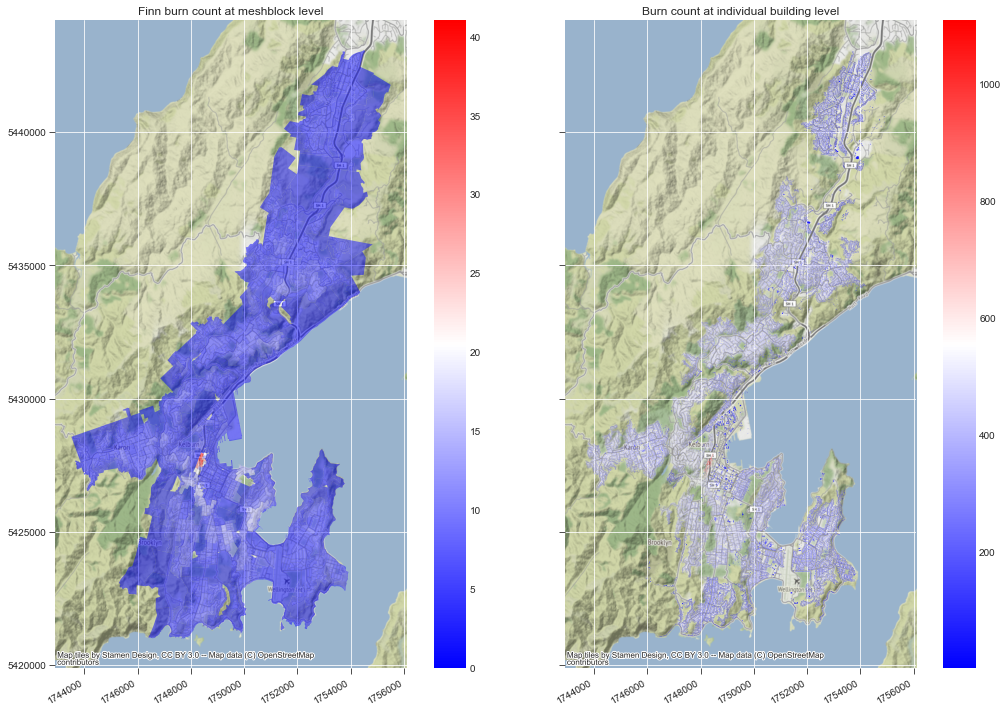

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-darkgrid')

FinnMeshblockShape = gpd.read_file(pathShapefile / 'Finn_MeshBlockSummary.shp')
# countShape = gpd.read_file(pathShapefile / 'Burn3000scenarioWellington.shp')

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(15, 10))

FinnMeshblockShape.plot(ax=ax1, column='WellWHV_Bu', cmap='bwr', alpha=0.5, legend=True)
ctx.add_basemap(ax1, crs=2193)
countShape.plot(ax=ax2, column='count', cmap='bwr', alpha=0.9, legend=True)
ctx.add_basemap(ax2, crs=2193)

ax1.set_title('Finn burn count at meshblock level')
ax1.ticklabel_format(useOffset=False, style='plain')
ax1.tick_params(direction='out', length=6)
ax2.set_title('Burn count at individual building level')
ax2.ticklabel_format(useOffset=False, style='plain')
ax2.tick_params(direction="out", length=6)

fig.autofmt_xdate()
plt.tight_layout()
plt.savefig(pathShapefile / 'ComparisonGISvsNetwork_3000Burn.png', dpi=600)
plt.show()

**Plot distributions**

Text(0.5, 1.0, 'Distribution of fires')

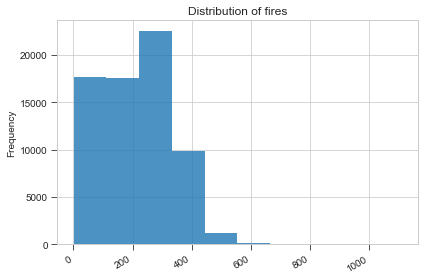

In [9]:
plt.style.use('seaborn-whitegrid')
fig, (ax1) = plt.subplots(nrows=1, ncols=1)#, figsize=(15, 10))

countConcatDf['count'].plot(kind='hist', ax=ax1, alpha=0.8)

ax1.set_title('Distribution of fires')
ax1.ticklabel_format(useOffset=False, style='plain')
ax1.tick_params(direction="out", length=6)

fig.autofmt_xdate()
plt.tight_layout()
# plt.savefig(pathShapefile / 'ComparisonGISvsNetwork_3000Burn.png', dpi=600)
plt.show()

(array([ 19., 145., 480., 704., 776., 494., 254.,  82.,  36.,   9.]),
 array([ 1. ,  2.9,  4.8,  6.7,  8.6, 10.5, 12.4, 14.3, 16.2, 18.1, 20. ]),
 <a list of 10 Patch objects>)

Text(0.5, 1.0, 'Distribution of ignitions')

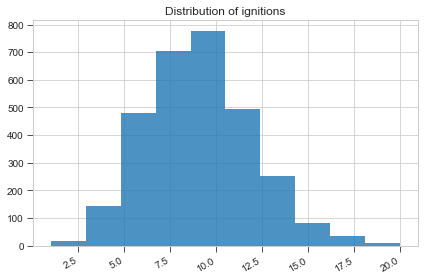

In [10]:
c = concatDf.drop_duplicates('scenario').compute()

plt.style.use('seaborn-whitegrid')
fig, (ax1) = plt.subplots(nrows=1, ncols=1)#, figsize=(15, 10))

ax1.hist(c['InitialIgnitions'], alpha=0.8)
# sns.distplot(c['InitialIgnitions'], ax=ax1)
# c['InitialIgnitions'].plot('hist', ax=ax1, alpha=0.8)

ax1.set_title('Distribution of ignitions')
ax1.ticklabel_format(useOffset=False, style='plain')
ax1.tick_params(direction="out", length=6)

fig.autofmt_xdate()
plt.tight_layout()
# plt.savefig(pathShapefile / 'ComparisonGISvsNetwork_3000Burn.png', dpi=600)
plt.show()

**Loss calculation**

In [45]:
costDataShape = gpd.read_file(pathShapefile / 'WellWHV_Buildings.shp')
costDataShape.columns

Index(['Replacemen', 'Combustibl', 'FloorArea', 'BLDG_ID', 'SA2_ID',
       'NightOccup', 'IgnProbBld', 'geometry'],
      dtype='object')

In [46]:
from dask.diagnostics import ProgressBar

# ccDf = concatDf[['source', 'scenario']].compute() 
costDataShape = gpd.read_file(pathShapefile / 'WellWHV_Buildings.shp')
costData = pd.DataFrame(costDataShape)
costData.drop(['Combustibl', 'FloorArea', 'BLDG_ID', 'SA2_ID','NightOccup','geometry'], axis=1, inplace=True)
# merge
ccDfLoss = dd.merge(concatDf, costData, how='left', left_on='source', right_index=True) # would need to work with Dask !!
ccDfLossCum = ccDfLoss.groupby(['scenario'])['Replacemen'].sum().reset_index()
# print(type(ccDfLoss), type(ccDfLossCum))

pbar = ProgressBar()
pbar.register()

lossCum = ccDfLossCum.compute()
print(f"the worst scenario is : \n {lossCum[lossCum['Replacemen'] == max(lossCum['Replacemen'])]}")

[########################################] | 100% Completed |  2min  0.6s
[########################################] | 100% Completed |  2min  0.7s
[########################################] | 100% Completed |  1min 59.5s
the worst scenario is : 
       scenario    Replacemen
1673      1465  2.178725e+10


In [13]:
# FinnLossesReport = np.array([0, 125000000, 263888888.9, 680555555.6, 1062500000, 1340277778, 2000000000, 
#               2555555556, 2972222222, 5020833333, 5402777778, 5854166667, 6305555556, 6444444444,
#               6965277778, 7243055556, 7381944444, 7902777778, 8145833333, 10263888889, 12347222222, 
#               13215277778, 14152777778])

# FinnProbabilityReport = np.array([0, 0.507380074, 0.556457565, 0.566789668, 0.584870849, 0.605535055, 
#                    0.719188192, 0.763099631, 0.770848708, 0.773431734, 0.804428044, 0.845756458,
#                    0.871586716, 0.871586716, 0.918081181, 0.923247232, 0.938745387, 0.949077491, 
#                    0.959409594, 0.972324723, 0.982656827, 0.985239852, 0.990405904])

pathFinn = Path('/Users/alex/Dropbox/Work/GNS/008_FFE/ProbaFFE/OutputFinn')
dataFinn3000 = pd.read_csv(pathFinn / 'ScenSumWellWHV_pfour_1-3000.csv')

lossLevels = np.arange(1000, 100e9, 10000)
excMoreFinn = np.array([np.count_nonzero(dataFinn3000.ReplacementValue.values >= x) for x in lossLevels])/3000

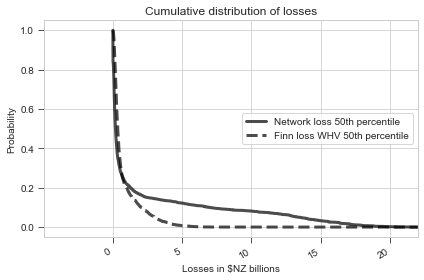

CPU times: user 2min 40s, sys: 3.06 s, total: 2min 43s
Wall time: 3min 16s


In [14]:
%%time
lossLevels = np.arange(1000, 100e9, 10000)
# excLess = np.array([np.count_nonzero(ccDflossCum.Replacemen.values <= x) for x in lossLevels])/3000
excMore = np.array([np.count_nonzero(lossCum.Replacemen.values >= x) for x in lossLevels])/3000


plt.style.use('seaborn-whitegrid')
fig, (ax1) = plt.subplots(nrows=1, ncols=1)#, figsize=(15, 10))

# ax1.plot(lossLevels/1e9, excLess, linewidth=2, linestyle='label='loss inferior')
ax1.plot(lossLevels/1e9, excMore, linewidth=3, linestyle='solid', alpha=0.7, color='black', label='Network loss 50th percentile')
# ax1.plot(FinnLosses/1e9, FinnProbability, linewidth=2, linestyle='dashed', label='Finn loss report')
ax1.plot(lossLevels/1e9, excMoreFinn, linewidth=3, linestyle='dashed', alpha=0.7, color='black', label='Finn loss WHV 50th percentile')

ax1.set_title('Cumulative distribution of losses')
ax1.ticklabel_format(useOffset=False, style= 'scientific')
ax1.tick_params(direction="out", length=6)
ax1.legend(loc="center right", frameon=True)
ax1.set(xlabel="Losses in $NZ billions", ylabel="Probability")
# ax1.set_xscale('log')
ax1.set_xlim([None, 22])

fig.autofmt_xdate()
plt.tight_layout()
plt.savefig(pathShapefile / 'ExcLosses.png', dpi=600)
plt.show()


(array([158.,  63.,  34.,  35.,  35.,  31.,  24.,  19.,  12.,  21.,  22.,
         35.,  33.,  35.,  25.,  22.,  25.,  13.,   8.,   3.,   2.,   0.,
          0.]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24]),
 <a list of 1 Patch objects>)

(array([292., 156.,  88.,  42.,  16.,   3.,   3.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24]),
 <a list of 23 Patch objects>)

Text(0.5, 1.0, 'Distribution of losses')

Text(0.5, 0, 'Loss billions $NZ')

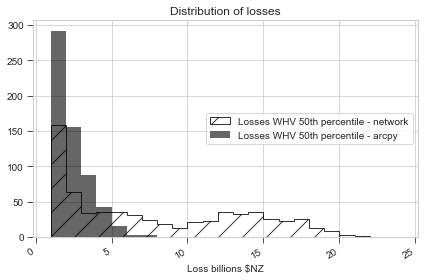

In [15]:
plt.style.use('seaborn-whitegrid')
fig, (ax1) = plt.subplots(nrows=1, ncols=1)#, figsize=(15, 10))

billionLossAlex = lossCum.Replacemen / 1e9
billionLossFinn = dataFinn3000.ReplacementValue / 1e9

# ccDflossCum.Replacemen.plot('hist', alpha=0.8)
ax1.hist(billionLossAlex, bins=np.arange(1,25), fill=False, histtype='step', hatch='/', color='black', alpha=0.8, label='Losses WHV 50th percentile - network')
ax1.hist(billionLossFinn, bins=np.arange(1,25), fill=True, color='black', alpha=0.6, label='Losses WHV 50th percentile - arcpy')

ax1.set_title('Distribution of losses')
ax1.ticklabel_format(useOffset=False, style= 'scientific')
ax1.tick_params(direction="out", length=6)
# ax1.set_yscale('log')
ax1.set_xlabel('Loss billions $NZ')
ax1.legend(loc="center right", frameon=True)

fig.autofmt_xdate()
plt.tight_layout()
plt.savefig(pathShapefile / 'DistributionLosses.png', dpi=600)
plt.show()

**Create Gif for largest scenario**

In [47]:
# keep only the ignition steps for the worst scenario
worstScenario = concatDf[concatDf['scenario']== 1465]
pbar = ProgressBar()
pbar.register()
worstScenario = worstScenario.compute()

# merge each line / source with geometry 
shape = gpd.read_file(pathShapefile / 'WellWHV_Buildings.shp')
shape.drop(['Combustibl', 'FloorArea', 'BLDG_ID', 'NightOccup'], axis=1, inplace=True)
worstScenario = pd.merge(worstScenario, shape, how='left', left_on='source', right_index=True)

[########################################] | 100% Completed |  1min 28.7s
[########################################] | 100% Completed |  1min 28.7s
[########################################] | 100% Completed |  1min 28.7s
[########################################] | 100% Completed |  1min 28.8s


In [71]:
def save_png(df, path):
    gdf = gpd.GeoDataFrame(df, geometry=df.geometry)
    mapShape = gpd.read_file(path / 'WellWHV_Buildings.shp')
    for t in tqdm(range(max(gdf.time))):
        gdfT = gdf[gdf.time<=t]
        # plot
        fig, ax = plt.subplots(figsize = (20,16)) 
        gdfT.plot(color="red", edgecolor=None, ax=ax)
        mapShape.geometry.boundary.plot(color=None,edgecolor='k',linewidth = 0.1,ax=ax)
        # savefig
        plt.savefig(os.path.join(str(pathShapefile), 'gif', f'{t}.png'), dpi=70)
        plt.close()

In [72]:
save_png(worstScenario, path=pathShapefile)

In [77]:
def create_gif(png_dir):
    import os
    import imageio
    import glob
    
    os.chdir(png_dir)
    images = []
    for file_name in tqdm(sorted(glob.glob('*.png'), key=os.path.getmtime)):
#         print(file_name)
        file_path = os.path.join(png_dir, file_name)
        images.append(imageio.imread(file_path))
    imageio.mimsave('/Users/alex/Dropbox/Work/GNS/008_FFE/ProbaFFE/FFE/shapefile/FFE.gif', images, fps=50)

In [78]:
%%time
create_gif('/Users/alex/Dropbox/Work/GNS/008_FFE/ProbaFFE/FFE/shapefile/gif')


CPU times: user 29.7 s, sys: 2.99 s, total: 32.7 s
Wall time: 41.7 s


In [75]:
from PIL import Image
im = Image.open('/Users/alex/Dropbox/Work/GNS/008_FFE/ProbaFFE/FFE/shapefile/FFE.gif')

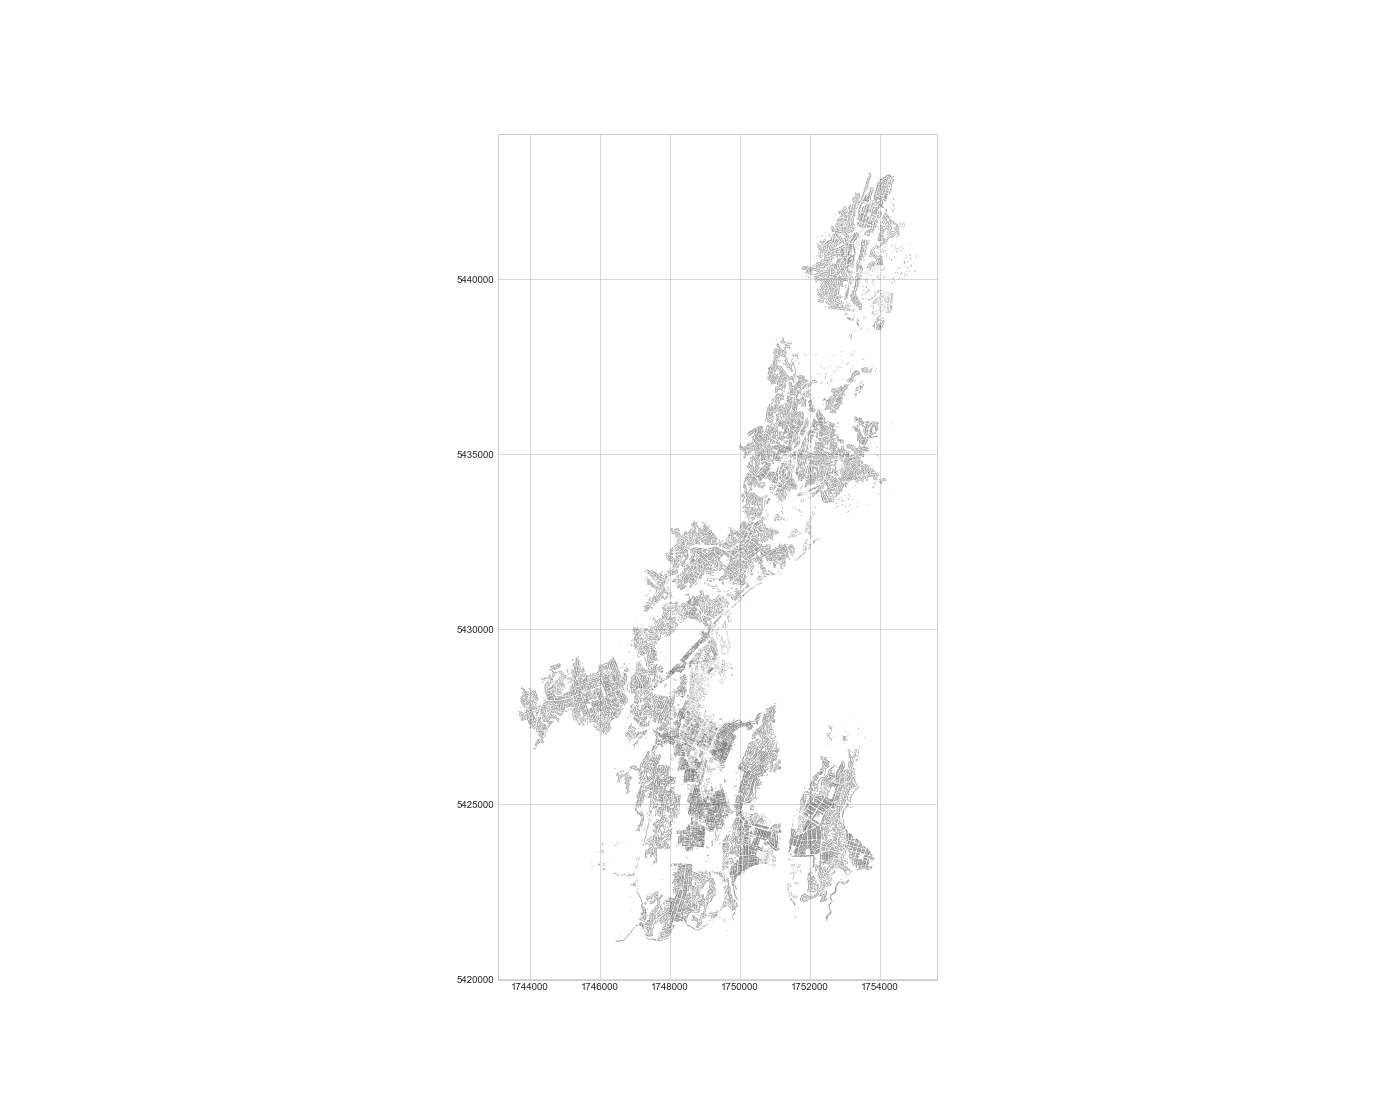

In [76]:
im

![alt text](/Users/alex/Dropbox/Work/GNS/008_FFE/ProbaFFE/FFE/shapefile/FFE.gif "FFE worst case")

![SegmentLocal](/Users/alex/Dropbox/Work/GNS/008_FFE/ProbaFFE/FFE/shapefile/FFE.gif "FFE worst case")